## Data Preporcessing

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  9 23:22:06 2020

@author: pmzha
"""
import functions as f
from tensorflow.python.keras import backend as k
import csv
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax


'''convert_to_dt'''
#source_path= "D:/USC/Lab/ChamSim/data/654.out"
#f.convert_to_dt(source_path)

'''read_dt'''
source_path= "./dt.csv"
#source_path= "D:/USC/Lab/ChamSim/data/dt.csv"
dataset_dt = pd.read_csv(source_path, header=None, index_col=None)
dataset_dt_ls=list(dataset_dt[0].astype(str))

'''tokenize'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset_dt_ls)
encoded_final = tokenizer.texts_to_sequences([' '.join(dataset_dt_ls)])[0]
final_vocab_size = len(tokenizer.word_index) + 1
'''input sequence window'''
look_back = 5
sequences = f.create_windowed_dataset(encoded_final, look_back)

'''Training data preprocessing'''
X, y = sequences[600000:1000000, :-1], sequences[600000:1000000, -1]
y = y.reshape(len(y), 1)

'''binay'''
y_binay=f.convert_to_binary(data=y)
print(X.shape,y.shape)

Using TensorFlow backend.


(400000, 5) (400000, 1)


In [2]:
'''split'''
'''val'''
test_ratio=0.2
X_train0, X_test = train_test_split(X, test_size=test_ratio, shuffle=False)
y_train0, y_test = train_test_split(y_binay, test_size=test_ratio, shuffle=False)

'''test'''
test_ratio=0.25
X_train, X_val = train_test_split(X_train0, test_size=test_ratio, shuffle=False)
y_train, y_val = train_test_split(y_train0, test_size=test_ratio, shuffle=False)

print("X shape:",X_train.shape,X_val.shape,X_test.shape)
print("y shape:",y_train.shape,y_val.shape,y_test.shape)

X shape: (240000, 5) (80000, 5) (80000, 5)
y shape: (240000, 16) (80000, 16) (80000, 16)


## Train Model

In [3]:
from my_model import my_model
'''train model'''
model_file_name='my_model.h5'
embedding_dim=10
i_dim=look_back
o_dim=y_train.shape[1]
batch_size=256
num_epochs=20
model_ = my_model(final_vocab_size, batch_size,embedding_dim, i_dim, o_dim)
history=model_.train(X_train, y_train,X_val, y_val, num_epochs, batch_size)
model_.model.save(model_file_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 10)             39170     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
Total params: 52,726
Trainable params: 52,726
Non-trainable params: 0
__________________________________________________

/home/pengmiao/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 240000 samples, validate on 80000 samples
Epoch 1/20
240000/240000 [==============================] - 16s 68us/step - loss: 0.2850 - accuracy: 0.8954 - val_loss: 0.2291 - val_accuracy: 0.9151
Epoch 2/20
240000/240000 [==============================] - 16s 65us/step - loss: 0.2253 - accuracy: 0.9158 - val_loss: 0.1790 - val_accuracy: 0.9151
Epoch 3/20
240000/240000 [==============================] - 16s 67us/step - loss: 0.1672 - accuracy: 0.9159 - val_loss: 0.1592 - val_accuracy: 0.9172
Epoch 4/20
240000/240000 [==============================] - 16s 67us/step - loss: 0.1596 - accuracy: 0.9161 - val_loss: 0.1579 - val_accuracy: 0.9172
Epoch 5/20
240000/240000 [==============================] - 16s 67us/step - loss: 0.1581 - accuracy: 0.9166 - val_loss: 0.1570 - val_accuracy: 0.9178
Epoch 6/20
240000/240000 [==============================] - 16s 68us/step - loss: 0.1558 - accuracy: 0.9174 - val_loss: 0.1533 - val_accuracy: 0.9176
Epoch 7/20
240000/240000 [=======================

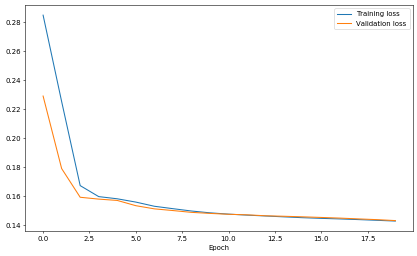

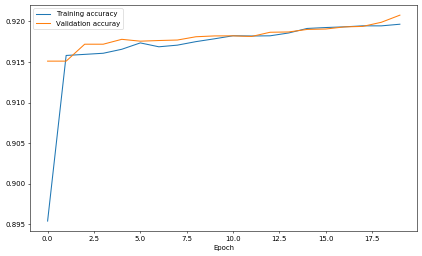

In [5]:
import matplotlib.pyplot as plt
fig1 = plt.figure(dpi=50, figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
#plt.ylabel("Training loss")
plt.legend(loc="best")
fig2 = plt.figure(dpi=50, figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuray')
plt.xlabel("Epoch")
plt.legend(loc="best")

## load model

In [31]:
'''
from tensorflow.keras.models import load_model
model_file_name='my_model.h5'
model_ = load_model(model_file_name)
'''

In [ ]:
y_pred = model_.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
aaaaa = np.packbits(np.array(y_test, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)
bbbbb = np.packbits(np.array(y_pred, dtype=np.bool).reshape(-1, 2, 8)[:, ::-1]).view(np.uint16)

In [ ]:
print(aaaaa[100:200])
print(bbbbb[100:200])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.array(aaaaa), np.array(bbbbb))
print(accuracy)